In [1]:
############################# Гипотеза о посещаемости избирательных участков #############################
# H0 - данные имеют распределение, отличное от нормального, или "между данными и распределениеи связи нет"
# H1 - данные имеют нормальное распределение с некоторысми неизвестными параметрами (сложная)
##########################################################################################################

import matplotlib.pyplot as plt
import requests

# установите модуль чтения Excel-файлов: pip install xlrd
import xlrd
import numpy as np
from scipy import stats
from scipy.stats import norm, chi2, expon
from decimal import Decimal

# центр-юг-Волга кроме Москвы
center = set([
    "Краснодарский край",
    "Ставропольский край",
    "Астраханская область",
    "Белгородская область",
    "Брянская область",
    "Владимирская область",
    "Волгоградская область",
    "Вологодская область",
    "Воронежская область",
    "Ивановская область",
    "Калужская область",
    "Кировская область",
    "Костромская область",
    "Курская область",
    "Липецкая область",
    "Нижегородская область",
    "Новгородская область",
    "Орловская область",
    "Пензенская область",
    "Ростовская область",
    "Рязанская область",
    "Самарская область",
    "Саратовская область",
    "Смоленская область",
    "Тамбовская область",
    "Тверская область",
    "Тульская область",
    "Ульяновская область",
    "Ярославская область"
])

In [2]:
# скачаем данные о посещаемости избирательных участков
url = ("http://www.vybory.izbirkom.ru/servlet/ExcelReportVersion?" + 
            "region=0&sub_region=0&root=1&global=1&" + 
            "vrn=100100084849062&tvd=100100084849066&" + 
            "type=453&vibid=100100084849066&condition=&" + 
            "action=show&version=null&prver=0&sortorder=0"
      )
c = requests.get(url).content
print(url)

# сохраним их в файл
with open('data/votes.xlsx', 'wb') as f:
    f.write(c)

# откроем
rb = xlrd.open_workbook(file_contents=c)
sheet = rb.sheet_by_index(0)
regions = [sheet.row_values(i)[-5] for i in range(13, 98)]
regions_to_take = list(map(lambda r : r in center, regions))

# явка к 10 часам
data10 = [float(sheet.row_values(i)[-4][:-1]) for i, r in zip(range(13, 98), regions_to_take) if r]
# явка к 12 часам
data12 = [float(sheet.row_values(i)[-3][:-1]) for i, r in zip(range(13, 98), regions_to_take) if r]
# явка к 18 часам
data18 = [float(sheet.row_values(i)[-1][:-1]) for i, r in zip(range(13, 98), regions_to_take) if r]
data = data12

http://www.vybory.izbirkom.ru/servlet/ExcelReportVersion?region=0&sub_region=0&root=1&global=1&vrn=100100084849062&tvd=100100084849066&type=453&vibid=100100084849066&condition=&action=show&version=null&prver=0&sortorder=0


In [3]:
# data - данные, которые мы проверяем на соответствие гипотизе
# H1 - гипотеза о распределении
# bin_count - сколько столбиков в гистограмме (bin_count - 1 = число степеней свободы)
# α - значимость, или, другими словами допустимая вероятность 
#     ошибки 1 рода - что, приняв гипотезу H1 мы отвергнем корректную H0
def test_data(data, H1, bin_count, α = 0.1, verbose = True):
    # разложение данных + попадёт на график
    h = plt.hist(data, bin_count)
    h_vals, h_borders = h[0], h[1]
    N = len(data)
    μ_ = sum(data) / N
    σ2_ = sum( (x-μ_) ** 2 for x in data ) / N
    if verbose:
        print("{} значений в интервале {:.2f}-{:.2f}".format(len(data), h_borders[0], h_borders[-1]))
        print('(μ\', σ2\') = ({:.3f}, {:.3f})'.format(μ_, σ2_))
    
    χ2 = chi2(bin_count - 1)
    if verbose:
        print("Для проверки гипотезы используется распределение χ2 c {} степенями свободы".format(bin_count - 1))
    
    # критическое значение вычисляется путём применения функции, обратной функции распределения
    # такая функция есть, потому что функция распределения χ2 строго возрастающая
    χ2α = χ2.ppf(α)
    if verbose:
        print("Критическое значение для α={} и {} степеней свободы равно {:.2f}".format(
            α, bin_count - 1, χ2α
        ))

    P = []
    for i in range(bin_count):
        P.append(H1.cdf(h_borders[i+1]) - H1.cdf(h_borders[i]))

    P_ = [p * N for p in P]
    step = h_borders[1] - h_borders[0]
    if verbose:
        plt.plot([x + step/2 for x in h_borders[:-1]], P_)
        plt.show()
    χ2n = Decimal(0.0)
    for i in range(bin_count):
        # !!! Важно !!! при малых значениях P[i] возможно деление на машинный ноль
        # обработаем как-нибудь эту ситуацию
        if P[i] == 0.0:
            continue
        χ2n += Decimal(h_vals[i] / N - P[i]) ** 2 / Decimal(P[i])
    χ2n *= Decimal(N)
    if verbose:
        print('χ2n = {:.3f}'.format(χ2n))
    χ2n = float(χ2n)
    
    p_value = 1 - χ2.cdf(χ2n)
    if verbose:
        print("Вероятность, что если H0 (гипотеза, что связи между данными и распределением нет) верна,")
        print("то величина ошибки больше либо равна полученному χ2n: p-value = {:.2f}%.".format(p_value * 100))
        print("Чем больше эта вероятность, тем лучше для альтернативной гипотезы H1,")
        print("однако, если эта величина близка к 1, данные можно заподозрить в фальсификации.")
    return (χ2n, p_value, bin_count, α, H1)
    # NB: Запомните, это абсолютно ничего не говорит о тот, что гипотеза H0 верна!!!
    # Да, это сложно принять :)

29 значений в интервале 20.44-34.14
(μ', σ2') = (27.772, 11.073)
Для проверки гипотезы используется распределение χ2 c 4 степенями свободы
Критическое значение для α=0.2 и 4 степеней свободы равно 1.65


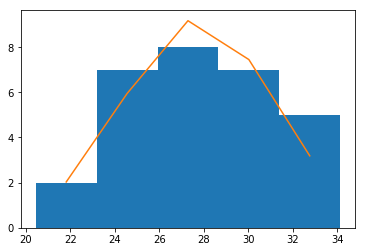

χ2n = 1.393
Вероятность, что если H0 (гипотеза, что связи между данными и распределением нет) верна,
то величина ошибки больше либо равна полученному χ2n: p-value = 84.55%.
Чем больше эта вероятность, тем лучше для альтернативной гипотезы H1,
однако, если эта величина близка к 1, данные можно заподозрить в фальсификации.


In [4]:
N = len(data)
μ_ = sum(data) / N
σ2_ = sum( (x-μ_) ** 2 for x in data ) / N

H1 = norm(μ_, σ2_ ** .5)
_ = test_data(data, H1, 5, 0.20)

In [5]:
# конечно же провести тест на нормальное распределение можно и гораздо проще :)
# это немного другой тест D'Agostino-Pearson Test:
stats.normaltest(data)

NormaltestResult(statistic=0.2096711124947861, pvalue=0.9004725875031654)

In [6]:
####################### Гипотеза о времени ответов сервиса #######################################

Min = 119.0, Max = 129.0


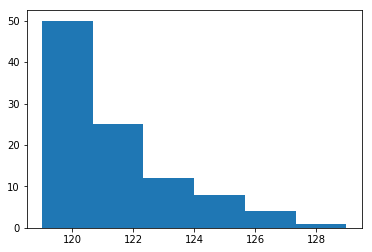

In [7]:
with open('data/times.log', 'r') as f:
    # убираем сервисные строчки, приводим к числу и берём первые 100
    data = [float(v) for v in f.readlines()[1:-4]][:100]
    
print("Min = {}, Max = {}".format(min(data), max(data)))
# В отличие от предыдущего пример, здесь с числом корзин нужно быть осторожным
# Измерения времени дискретные, поэтому нужно сделать так, чтобы они не "слипались"
bins = 6
h = plt.hist(data, bins)
plt.show()

100 значений в интервале 119.00-129.00
(μ', σ2') = (121.210, 4.366)
Для проверки гипотезы используется распределение χ2 c 5 степенями свободы
Критическое значение для α=0.2 и 5 степеней свободы равно 2.34


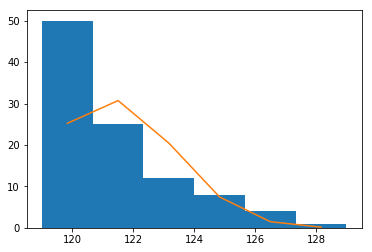

χ2n = 37.647
Вероятность, что если H0 (гипотеза, что связи между данными и распределением нет) верна,
то величина ошибки больше либо равна полученному χ2n: p-value = 0.00%.
Чем больше эта вероятность, тем лучше для альтернативной гипотезы H1,
однако, если эта величина близка к 1, данные можно заподозрить в фальсификации.


NormaltestResult(statistic=22.320874453814103, pvalue=1.4226029230845182e-05)

In [8]:
# проверка на нормальность!

N = len(data)
μ_ = sum(data) / N
σ2_ = sum( (x-μ_) ** 2 for x in data ) / N

H1 = norm(μ_, σ2_ ** .5)
test_data(data, H1, bins, 0.2)

# или так тоже можно.
stats.normaltest(data)

# как видно, по обоим тестам гипотеза провалилась - p-value около 0.

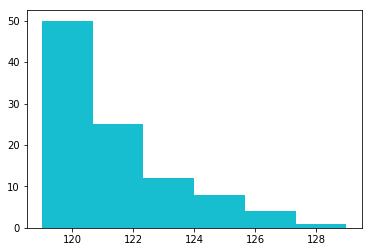

In [9]:
# а может экспоненциальное?
results = []
# сделаем Grid Search - поиск по сетке параметров.
# параметры экспоненциального распределения - смещение и крутизна
for d in [x / 10. for x in range(-10, 10)]:
    for λ in [x / 100. for x in range(25, 50)]:
        loc = d + min(data) # смещение
        H1 = expon(scale=1./λ, loc=loc)
        r = test_data(data, H1, bins, 0.2, verbose=False)
        results.append((*r, d, λ))

d = 119.0 + (0.0); λ = 0.4
100 значений в интервале 119.00-129.00
(μ', σ2') = (121.210, 4.366)
Для проверки гипотезы используется распределение χ2 c 5 степенями свободы
Критическое значение для α=0.05 и 5 степеней свободы равно 1.15


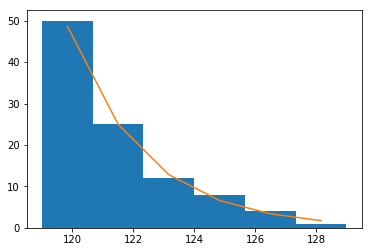

χ2n = 0.819
Вероятность, что если H0 (гипотеза, что связи между данными и распределением нет) верна,
то величина ошибки больше либо равна полученному χ2n: p-value = 97.58%.
Чем больше эта вероятность, тем лучше для альтернативной гипотезы H1,
однако, если эта величина близка к 1, данные можно заподозрить в фальсификации.


In [10]:
best = sorted(results)[0]
H, d, λ = best[-3], best[-2], best[-1]
print("d = {} + ({}); λ = {}".format(min(data), d, λ))
_ = test_data(data, H, bins, 0.05)

100 значений в интервале 119.00-129.00
(μ', σ2') = (121.210, 4.366)
Для проверки гипотезы используется распределение χ2 c 5 степенями свободы
Критическое значение для α=0.05 и 5 степеней свободы равно 1.15


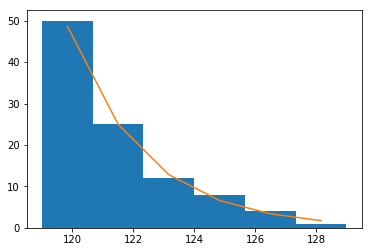

χ2n = 0.819
Вероятность, что если H0 (гипотеза, что связи между данными и распределением нет) верна,
то величина ошибки больше либо равна полученному χ2n: p-value = 97.58%.
Чем больше эта вероятность, тем лучше для альтернативной гипотезы H1,
однако, если эта величина близка к 1, данные можно заподозрить в фальсификации.


In [11]:
# экспоненциально распределение лишь частный случай хи-квадрат expon = chi2(k=2)
# попробуем его
λ = 0.4 * 2
H1 = chi2(2, loc=min(data), scale=1./λ)
_ = test_data(data, H1, bins, 0.05)